In [1]:
import numpy as np
import tensorflow as tf
import cv2
from lucid.modelzoo import vision_models
from lucid.misc.io import show, load, save
from lucid.misc.tfutil import create_session

import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render

from lucid.optvis.objectives import wrap_objective

C:\ProgramData\Anaconda3\envs\faceswap\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
model = vision_models.InceptionV1()
model.load_graphdef()

tf.test.is_gpu_available()

True

In [3]:
def scale_img(image, max_size):
    #image: a numpy arary
    #max_size: width and hight you want to limit.
    if type(max_size) == int:
        w = h = max_size
    elif type(max_size) == tuple or type(max_size) == list:
        w, h = max_size[0], max_size[1]

    img_w, img_h = image.shape[1], image.shape[0]
    if (w, h) < (img_w, img_h):
        if img_w < img_h:
            width = int(h * img_w / img_h)
            image = cv2.resize(image,dsize =(width, h),interpolation = cv2.INTER_CUBIC)
        else:
            hight = int(w * img_h / img_w)
            image = cv2.resize(image,dsize =(w, hight),interpolation = cv2.INTER_CUBIC)
    return image

shape of content image: (437, 778, 3) 
shape of style image: (778, 1000, 3)



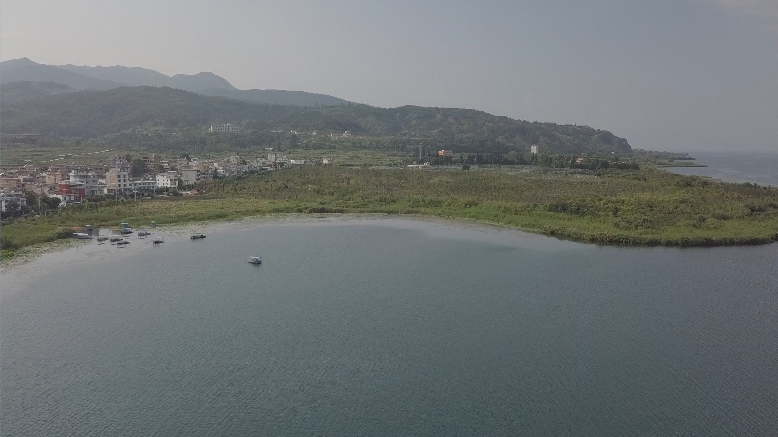


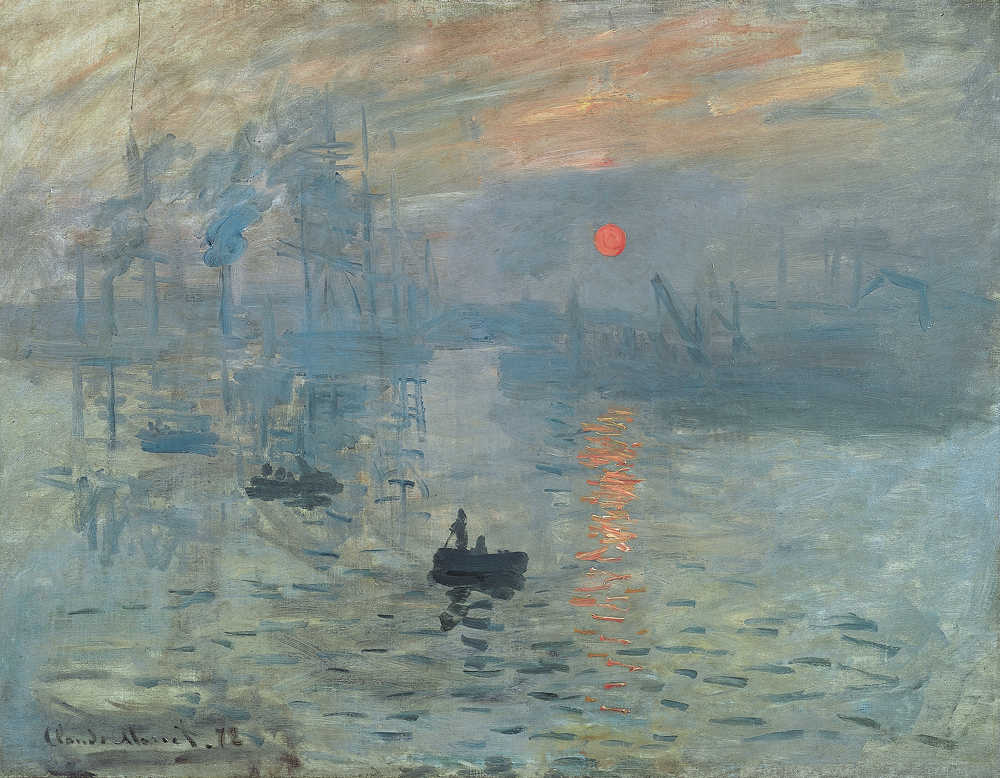

In [10]:
content_image = load("lake1.jpg")
style_image = load("Claude_Monet_large.jpg")#[..., :3] # removes transparency channel

style_image = scale_img(style_image, 1000)
if min(style_image.shape[0:2]) < max(content_image.shape[0:2]):
    content_image = scale_img(content_image, min(style_image.shape[0:2]))  #style要大于content

print("shape of content image:",content_image.shape, "\nshape of style image:", style_image.shape)

show(content_image)
show(style_image)

In [6]:
style_layers = [
  'conv2d2',
  'mixed3a',
  'mixed4a',
  'mixed4b',
  'mixed4c',
]

content_layers = [
  'mixed3b',
]

In [7]:
def style_transfer_param(content_image, style_image, decorrelate=True, fft=True):
    style_transfer_input = param.image(*content_image.shape[:2], decorrelate=decorrelate, fft=fft)[0]
    content_input = content_image
    style_input = tf.random_crop(style_image, content_image.shape)
    return tf.stack([style_transfer_input, content_input, style_input])

# these constants help remember which image is at which batch dimension
TRANSFER_INDEX = 0
CONTENT_INDEX = 1
STYLE_INDEX = 2
print(style_transfer_param(content_image, style_image).shape)

(3, 524, 933, 3)



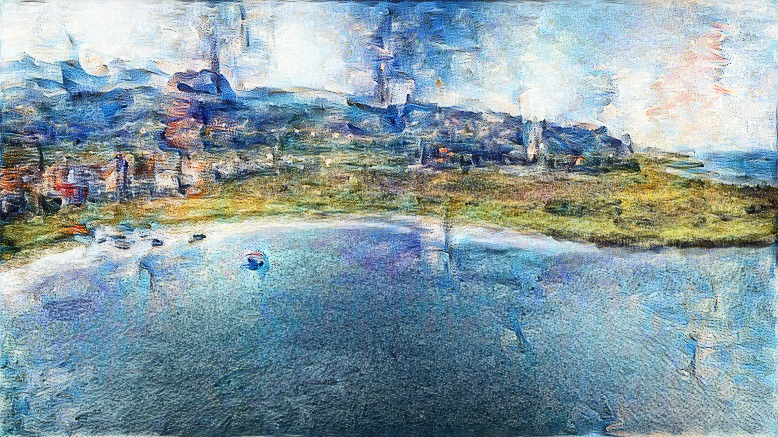
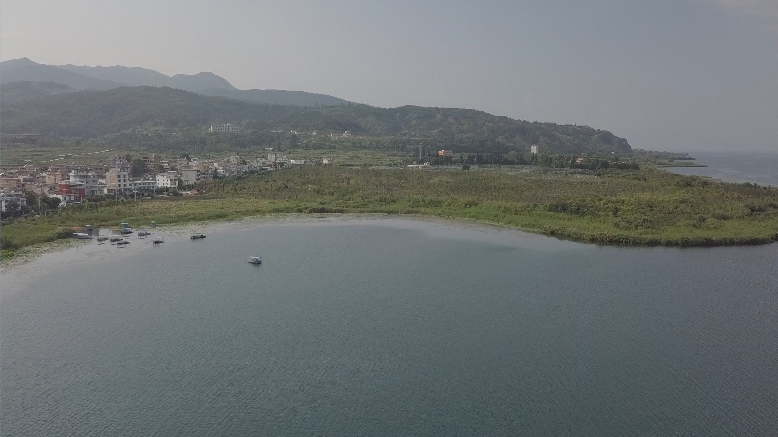
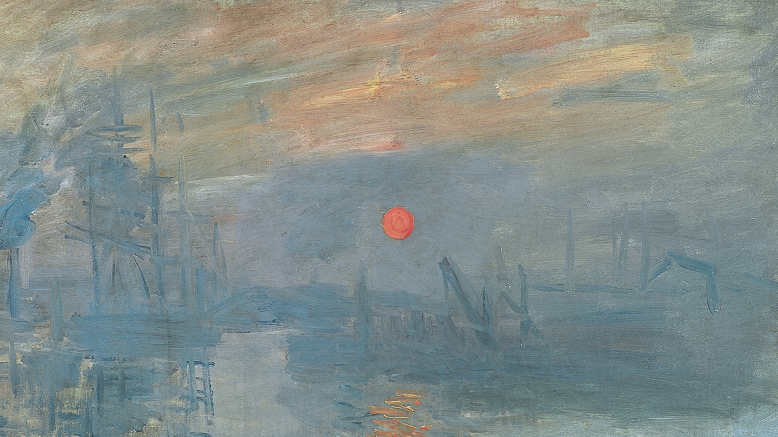

In [11]:
def mean_L1(a, b):
  return tf.reduce_mean(tf.abs(a-b))

@wrap_objective
def activation_difference(layer_names, activation_loss_f=mean_L1, transform_f=None, difference_to=CONTENT_INDEX):
  def inner(T):
    # first we collect the (constant) activations of image we're computing the difference to
    image_activations = [T(layer_name)[difference_to] for layer_name in layer_names]
    if transform_f is not None:
      image_activations = [transform_f(act) for act in image_activations]
    
    # we also set get the activations of the optimized image which will change during optimization
    optimization_activations = [T(layer)[TRANSFER_INDEX] for layer in layer_names]
    if transform_f is not None:
      optimization_activations = [transform_f(act) for act in optimization_activations]
    
    # we use the supplied loss function to compute the actual losses
    losses = [activation_loss_f(a, b) for a, b in zip(image_activations, optimization_activations)]
    return tf.add_n(losses) 
    
  return inner

def gram_matrix(array, normalize_magnitue=True):
  channels = tf.shape(array)[-1]
  array_flat = tf.reshape(array, [-1, channels])
  gram_matrix = tf.matmul(array_flat, array_flat, transpose_a=True)
  if normalize_magnitue:
    length = tf.shape(array_flat)[0]
    gram_matrix /= tf.cast(length, tf.float32)
  return gram_matrix

param_f = lambda: style_transfer_param(content_image, style_image)

content_obj = 100 * activation_difference(content_layers, difference_to=CONTENT_INDEX)
content_obj.description = "Content Loss"

style_obj = activation_difference(style_layers, transform_f=gram_matrix, difference_to=STYLE_INDEX)
style_obj.description = "Style Loss"

objective = - content_obj - style_obj

vis = render.render_vis(model, objective, param_f=param_f, thresholds=[512], verbose=False, print_objectives=[content_obj, style_obj])[-1]
show(vis)

In [ ]:
save(vis[0], "out.jpg")

In [13]:
help(render)

Help on module lucid.optvis.render in lucid.optvis:

NAME
    lucid.optvis.render - Provides render_vis() for actually rendering visualizations.

DESCRIPTION
    This module primarily provides render_vis() for rendering visualizations.
    It also provides some utilities in case you need to create your own rendering
    function.

FUNCTIONS
    import_model(model, t_image, t_image_raw)
    
    make_optimizer(optimizer, args)
    
    make_print_objective_func(print_objectives, T)
    
    make_t_image(param_f)
    
    make_transform_f(transforms)
    
    make_vis_T(model, objective_f, param_f=None, optimizer=None, transforms=None, relu_gradient_override=False)
        Even more flexible optimization-base feature vis.
        
        This function is the inner core of render_vis(), and can be used
        when render_vis() isn't flexible enough. Unfortunately, it's a bit more
        tedious to use:
        
        >  with tf.Graph().as_default() as graph, tf.Session() as sess:
   